# Project 2 — Sgr A* : S2 Stellar Orbit — Joint Fit of Astrometry + Radial Velocities

**Team:** Eling Cheg and Allison Trusko  
**Course:** ASTRON 1221  
**Date:** 2025-12-04  
**GitHub Repository Link:** https://github.com/echengpython/Sgr-A-Stellar-Orbit---Black-Hole-Mass-Measurement-.git

**Summary:** Fit the orbit of S2 around Sgr A* using Keplerian dynamics, simultaneously fit the distance to the Galactic Center (R₀) and the black hole mass, and assess uncertainties and goodness-of-fit. Uses `scipy.optimize.least_squares` for joint astrometry+RV fitting.



In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from astropy.time import Time
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    "figure.figsize": (8,6),
    "font.size": 12
})

# constants
AU_PER_PC = 206265.0           # AU in one parsec
AU_IN_KM = 1.495978707e8       # km
SEC_IN_YEAR = 31557600.0       # seconds (Julian year)
KM_S_PER_AU_PER_YEAR = AU_IN_KM / SEC_IN_YEAR  # conversion factor
GMSUN_AU3_PER_YR2 = 4 * (np.pi**2)  # in units such that M_sun = a_AU^3 / P_year^2 when using 2pi factor -> actually 4*pi^2
# Explanation: Kepler in units (AU, yr, M_sun): 4π^2 a^3 / (G * P^2) = GM ; Standard simplified relation:
# M(Msun) = a(AU)^3 / P(yr)^2  when constant chosen appropriately; using 4π^2 cancels if using angular frequency form.
print("Environment ready.")


Environment ready.


In [258]:
# === Fetch S2 astrometry from Vizier ===
import numpy as np
import pandas as pd

def _validate_df_astrometry(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ["year", "x_mas", "y_mas"]:
        if c not in df.columns:
            raise ValueError(f"Required column '{c}' missing after VizieR mapping.")
    if "x_err_mas" not in df.columns:
        df["x_err_mas"] = 1.5
    if "y_err_mas" not in df.columns:
        df["y_err_mas"] = 1.5
    return df.sort_values("year").reset_index(drop=True)

try:
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    Vizier.columns = ["*"]

    # Gillessen+ 2009 ApJ 707 L114 table1: S2 astrometry
    cats = Vizier.get_catalogs("J/ApJ/707/L114/table1")
    if not cats:
        raise RuntimeError("No tables for J/ApJ/707/L114/table1")

    tab = cats[0].to_pandas()

    year_ast = pd.to_numeric(tab["Ep.A"], errors="coerce").values
    x_mas    = pd.to_numeric(tab["oRA"],  errors="coerce").values
    x_err    = pd.to_numeric(tab["e_oRA"], errors="coerce").values
    y_mas    = pd.to_numeric(tab["oDE"],  errors="coerce").values
    y_err    = pd.to_numeric(tab["e_oDE"], errors="coerce").values

    df = pd.DataFrame({
        "year": year_ast,
        "x_mas": x_mas,
        "y_mas": y_mas,
        "x_err_mas": x_err,
        "y_err_mas": y_err
    })
    df = df[np.isfinite(df["year"]) & np.isfinite(df["x_mas"]) & np.isfinite(df["y_mas"])].copy()
    df = _validate_df_astrometry(df)
    print(f"Loaded S2 astrometry (J/ApJ/707/L114/table1): {len(df)} rows.")
    print("Columns:", df.columns.tolist())

except Exception as e:
    raise RuntimeError(
        "Failed to load S2 astrometry from VizieR. Ensure internet access and astroquery is installed.\n"
        f"Original error: {e}"
    )
display(df.head())


Loaded S2 astrometry (J/ApJ/707/L114/table1): 96 rows.
Columns: ['year', 'x_mas', 'y_mas', 'x_err_mas', 'y_err_mas']


,year,x_mas,y_mas,x_err_mas,y_err_mas
0,1992.224,-6.400000,172.000000,4.6,4.7
1,1994.314,-28.500000,179.000000,4.8,3.4
2,1995.439,-42.599998,164.100006,1.0,1.0
3,1995.534,-37.299999,172.100006,3.8,4.3
4,1996.253,-43.400002,164.399994,3.6,3.6


In [259]:
def solve_kepler(M, e, tol=1e-12, maxiter=200):
    M = np.array(M, dtype=float)
    E = M.copy()
    # Newton-Raphson
    for _ in range(maxiter):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        dE = f / fp
        E -= dE
        if np.max(np.abs(dE)) < tol:
            break
    return E

def orb_elements_to_sky(t_years, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
                        x0_mas=0.0, y0_mas=0.0, vx0_masyr=0.0, vy0_masyr=0.0, tref_year=None):
    """
    Return sky-plane positions (x_mas, y_mas) including frame offset (x0,y0) and linear drift (vx0,vy0) about tref.
    """
    t = np.array(t_years, dtype=float)
    if tref_year is None:
        tref_year = np.mean(t)

    i = np.deg2rad(i_deg)
    Omega = np.deg2rad(Omega_deg)
    omega = np.deg2rad(omega_deg)

    M = 2*np.pi*(t - T0_year) / P_years
    E = solve_kepler(M, e)

    # orbital plane coords (mas)
    xprime = a_mas*(np.cos(E) - e)
    yprime = a_mas*np.sqrt(1-e*e)*np.sin(E)

    # rotate to sky
    cosO, sinO = np.cos(Omega), np.sin(Omega)
    cosw, sinw = np.cos(omega), np.sin(omega)
    cosi = np.cos(i)

    x_orb = xprime*(cosO*cosw - sinO*sinw*cosi) - yprime*(cosO*sinw + sinO*cosw*cosi)
    y_orb = xprime*(sinO*cosw + cosO*sinw*cosi) - yprime*(sinO*sinw - cosO*cosw*cosi)

    # add frame offset + drift
    dt = (t - tref_year)
    x = x_orb + x0_mas + vx0_masyr*dt
    y = y_orb + y0_mas + vy0_masyr*dt

    # true anomaly
    f = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2.), np.sqrt(1-e)*np.cos(E/2.))
    return x, y, E, f


def radial_velocity_model(t_years, a_mas, e, i_deg, omega_deg, P_years, T0_year, R0_kpc, V0_kms=0.0):
    """
    Compute radial velocity (km/s) of S2 for given orbital elements and distance R0_kpc.
    Derived from orbital geometry and Kepler's laws.
    - a_mas: angular semimajor axis (mas)
    - R0_kpc: distance to GC in kpc (free parameter)
    Returns v_rad_kms array.
    """
    # convert a_mas -> a_AU using R0_kpc
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)  # a_mas -> radians
    R0_pc = R0_kpc * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # mean motion (rad/yr)
    n = 2*np.pi / P_years
    # compute true anomaly f
    _, _, _, f = orb_elements_to_sky(t_years, a_mas, e, i_deg, 0.0, omega_deg, P_years, T0_year)
    i = np.deg2rad(i_deg)
    omega = np.deg2rad(omega_deg)
    # RV in AU/yr:
    v_AUyr = n * a_AU / np.sqrt(1 - e**2) * (np.cos(omega + f) + e*np.cos(omega)) * np.sin(i)
    # convert to km/s:
    v_kms = v_AUyr * KM_S_PER_AU_PER_YEAR
    return v_kms + V0_kms, a_AU  # return a_AU for diagnostics


In [260]:
# === Residuals + guesses/bounds + helper ===

def residuals_joint(theta, t_ast, x_obs, y_obs, x_err, y_err, r0_prior=None):
    (a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
     R0_kpc, x0, y0, vx0, vy0, log_s_xy) = theta

    x_mod, y_mod, _, _ = orb_elements_to_sky(
        t_ast, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0, tref_year=None
    )

    s_xy = np.exp(log_s_xy)
    rx = (x_obs - x_mod) / np.sqrt(x_err**2 + s_xy**2)
    ry = (y_obs - y_mod) / np.sqrt(y_err**2 + s_xy**2)
    res = np.concatenate([rx, ry])

    # --- OPTIONAL GAUSSIAN PRIOR ON R0 (keeps R0 free but regularized) ---
    if r0_prior is not None:
        R0_mu, R0_sigma = r0_prior
        if R0_sigma > 0:
            res = np.concatenate([res, np.array([(R0_kpc - R0_mu)/R0_sigma])])

    return res

def _freeze_params_to_value(lower, upper, idx, value):
    lower[idx] = value
    upper[idx] = value

def build_initial_guess_and_bounds():
    # R0 back to being FIT — set a sensible prior range
    R0_init = 8.2  # kpc
    R0_min  = 7.5
    R0_max  = 8.7

    theta0 = np.array([
        125.0, 0.88, 134.0, 226.0, 66.0, 15.9, 2002.33,  # orbit
        R0_init,                                         # R0_kpc (free)
        0.0, 0.0, 0.0, 0.0,                              # x0,y0,vx0,vy0
        np.log(0.5)                                      # log_s_xy (mas)
    ])

    lower = np.array([
         80.0, 0.5,   0.0,   0.0,   0.0, 10.0, 2001.0,
         R0_min,
        -10.0, -10.0, -2.0, -2.0,
        np.log(0.05)
    ])
    upper = np.array([
        200.0, 0.99, 180.0, 360.0, 360.0, 25.0, 2004.0,
        R0_max,
         10.0,  10.0,  2.0,  2.0,
        np.log(2.0)
    ])
    return theta0, lower, upper

def _xy_model_only(years, p):
    x, y, *_ = orb_elements_to_sky(
        years, p[0], p[1], p[2], p[3], p[4], p[5], p[6],
        x0_mas=p[8], y0_mas=p[9], vx0_masyr=p[10], vy0_masyr=p[11]
    )
    return x, y



In [261]:
def fit_joint_astrometry_rv(df, rv_column='rv_kms', rv_err_column='rv_err_kms', rv_weights=1.0, loss='huber'):
    """
    df: DataFrame with columns year, x_mas, y_mas, x_err_mas, y_err_mas, optionally rv_kms, rv_err_kms
    Returns: result dict with popt, perr, cov, res (least_squares result)
    """
    # astrometry arrays
    t_ast = df['year'].values
    x_obs = df['x_mas'].values
    y_obs = df['y_mas'].values
    x_err = df.get('x_err_mas', pd.Series(np.ones_like(x_obs)*1.5)).values
    y_err = df.get('y_err_mas', pd.Series(np.ones_like(y_obs)*1.5)).values

    # radial velocities (if present)
    if (rv_column in df.columns) and (rv_err_column in df.columns):
        t_rv = df['year'].values
        rv_obs = df[rv_column].values
        rv_err = df[rv_err_column].values
        rv_mask = np.isfinite(rv_obs) & np.isfinite(rv_err)
    else:
        t_rv, rv_obs, rv_err, rv_mask = None, None, None, None

    theta0, lower, upper = build_initial_guess_and_bounds()
    print("Initial guess (theta0):", theta0)
    print("Bounds lower:", lower)
    print("Bounds upper:", upper)
    res = least_squares(residuals_joint, theta0, args=(t_ast, x_obs, y_obs, x_err, y_err, t_rv, rv_obs, rv_err, rv_mask, rv_weights),
                        bounds=(lower, upper), loss=loss, max_nfev=50000)
    popt = res.x
    # covariance estimate: inv(J^T J) * s^2
    try:
        J = res.jac
        JTJ = J.T.dot(J)
        dof = (2*len(t_ast) + (np.sum(rv_mask) if rv_mask is not None else 0)) - len(popt)
        s2 = np.sum(res.fun**2) / max(1, dof)
        cov = np.linalg.inv(JTJ) * s2
        perr = np.sqrt(np.abs(np.diag(cov)))
    except Exception as e:
        print("Covariance estimation failed:", e)
        cov = None
        perr = None
    return dict(popt=popt, perr=perr, cov=cov, res=res)


In [262]:
def fit_joint_astrometry_rv(df, rv_column=None, rv_err_column=None, rv_weights=1.0, loss='huber'):
    """
    Kept function name for compatibility, but now it's astrometry-only.
    """
    t_ast = df['year'].values
    x_obs = df['x_mas'].values
    y_obs = df['y_mas'].values
    x_err = df.get('x_err_mas', pd.Series(np.ones_like(x_obs)*1.5)).values
    y_err = df.get('y_err_mas', pd.Series(np.ones_like(y_obs)*1.5)).values

    theta0, lower, upper = build_initial_guess_and_bounds()
    print("Initial guess (theta0):", theta0)
    print("Bounds lower:", lower)
    print("Bounds upper:", upper)

    res = least_squares(
        residuals_joint, theta0,
        args=(t_ast, x_obs, y_obs, x_err, y_err),
        bounds=(lower, upper), loss=loss, max_nfev=50000
    )
    popt = res.x

    # Covariance estimate: inv(J^T J) * s^2
    try:
        J = res.jac
        JTJ = J.T.dot(J)
        dof = (2*len(t_ast)) - len(popt)
        s2 = np.sum(res.fun**2) / max(1, dof)
        cov = np.linalg.inv(JTJ) * s2
        perr = np.sqrt(np.abs(np.diag(cov)))
    except Exception as e:
        print("Covariance estimation failed:", e)
        cov = None
        perr = None
    return dict(popt=popt, perr=perr, cov=cov, res=res)

# ---------- Astrometry-only fit ----------
def fit_astrometry_only(df, loss='linear', r0_prior=None):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    theta0, lower, upper = build_initial_guess_and_bounds()

    return least_squares(
        residuals_joint, theta0,
        args=(t, x, y, xerr, yerr, r0_prior),  # <-- prior flows into residuals
        bounds=(lower, upper), loss=loss, max_nfev=50000
    )


def _cov_from_svd(res, dof, rcond=1e-12):
    J = res.jac
    U, s, Vt = np.linalg.svd(J, full_matrices=False)
    s2 = np.sum(res.fun**2) / max(1, dof)
    tol = rcond * s.max() if s.size else 0.0
    w = np.zeros_like(s)
    mask = s > tol
    w[mask] = 1.0 / (s[mask]**2)
    cov = (Vt.T * w) @ Vt * s2
    return cov


In [263]:
def summarize_fit(df, res, label="astrometry-only"):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    theta = res.x
    (a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
     R0_kpc, x0, y0, vx0, vy0, log_s_xy) = theta
    s_xy = np.exp(log_s_xy)

    xmod, ymod, _, _ = orb_elements_to_sky(
        t, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0, y0, vx0, vy0
    )

    chi2_ast = np.sum(((x - xmod)/np.sqrt(xerr**2 + s_xy**2))**2
                      + ((y - ymod)/np.sqrt(yerr**2 + s_xy**2))**2)
    N_ast = 2*len(t)
    N_params = len(theta)
    dof = N_ast - N_params
    red = chi2_ast / max(dof, 1)

    print(f"[{label}] chi2_total={chi2_ast:.2f}  dof={dof}  reduced_chi2={red:.3f}")

    # Covariance via SVD
    try:
        J = res.jac
        U, S, Vt = np.linalg.svd(J, full_matrices=False)
        s2 = chi2_ast / max(dof, 1)
        cov = (Vt.T * (s2 / (S**2))) @ Vt
    except Exception:
        cov = None

    return cov

In [264]:
def eval_linear_at_solution(df, popt):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    # Freeze all params at popt
    lower = popt.copy()
    upper = popt.copy()
    for i in range(len(popt)):
        _freeze_params_to_value(lower, upper, i, popt[i])

    res_lin = least_squares(
        residuals_joint, popt,
        args=(t, x, y, xerr, yerr),
        bounds=(lower, upper), loss='linear', max_nfev=1
    )

    r = res_lin.fun
    chi2 = np.sum(r**2)
    N_params = len(popt)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[linear eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return res_lin, chi2, red

def eval_chi2_no_jitter(df, popt):
    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    th = popt.copy()
    i_sxy = 12
    near_zero_log = np.log(1e-12)
    th[i_sxy] = near_zero_log

    lower = th.copy(); upper = th.copy()
    for i in range(len(th)):
        _freeze_params_to_value(lower, upper, i, th[i])

    res_lin = least_squares(
        residuals_joint, th,
        args=(t, x, y, xerr, yerr),
        bounds=(lower, upper), loss='linear', max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(th)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[no-jitter eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return chi2, red


In [265]:
# ================== RUN FITS + REPORT ==================
# Evaluation helpers 

def eval_linear_at_solution(df, popt):
    import numpy as np
    from scipy.optimize import least_squares

    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    # Evaluate residuals/Jacobian at popt with NO bounds
    res_lin = least_squares(
        residuals_joint, popt,
        args=(t, x, y, xerr, yerr, None),   # r0_prior=None for evaluation only
        bounds=(-np.inf, np.inf),
        loss='linear',
        max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(popt)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[linear eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return res_lin, chi2, red


def eval_chi2_no_jitter(df, popt):
    import numpy as np
    from scipy.optimize import least_squares

    t = df['year'].values
    x = df['x_mas'].values; y = df['y_mas'].values
    xerr = df['x_err_mas'].values; yerr = df['y_err_mas'].values

    th = popt.copy()
    i_sxy = 12   # log_s_xy index in the astrometry-only model
    th[i_sxy] = np.log(1e-12)  # effectively zero jitter

    # Evaluate at th with NO bounds
    res_lin = least_squares(
        residuals_joint, th,
        args=(t, x, y, xerr, yerr, None),   # r0_prior=None for evaluation only
        bounds=(-np.inf, np.inf),
        loss='linear',
        max_nfev=1
    )

    r = res_lin.fun
    chi2 = float(np.sum(r**2))
    N_params = len(th)
    N_ast = 2*len(t)
    dof = N_ast - N_params
    red = chi2 / max(dof, 1)
    print(f"[no-jitter eval] chi2={chi2:.2f}, dof={dof}, reduced chi2={red:.3f}")
    return chi2, red



# ================== FIT with R0 PRIOR ==================
# Soft prior keeps R0 free but prevents singular covariance
# You can adjust these numbers; (8.2 ± 0.2 kpc) is a light prior.
R0_PRIOR = (8.2, 0.2)

resA = fit_astrometry_only(df, loss='huber', r0_prior=R0_PRIOR)
covA = summarize_fit(df, resA, label="astrometry-only + R0 prior")

# Post-fit diagnostics (no prior here; these are just evaluations)
popt = resA.x
_ = eval_linear_at_solution(df, popt)
_ = eval_chi2_no_jitter(df, popt)

# Keep covariance for Cell 11 (mass uncertainty calculation)
cov = covA


[astrometry-only + R0 prior] chi2_total=215.53  dof=179  reduced_chi2=1.204
[linear eval] chi2=215.53, dof=179, reduced chi2=1.204
[no-jitter eval] chi2=1295.73, dof=179, reduced chi2=7.239


In [266]:
def mass_from_fitted(popt):
    # popt: [a_mas,e,i_deg,Omega,omega,P,T0,R0_kpc,V0]
    a_mas = popt[0]
    P = popt[5]
    R0_kpc = popt[7]
    # convert a_mas -> a_AU using R0_kpc
    rad = (a_mas/1000.0)/3600.0 * (np.pi/180.0)
    R0_pc = R0_kpc * 1000.0
    a_AU = rad * R0_pc * AU_PER_PC
    # Kepler: M (Msun) = a_AU^3 / P_years^2
    M = a_AU**3 / (P**2)
    return M, a_AU

Mfit, aAU = mass_from_fitted(popt)
print(f"Fitted semi-major axis = {popt[0]:.4f} mas -> {aAU:.2f} AU (using R0={popt[7]:.3f} kpc)")
print(f"Fitted orbital period = {popt[5]:.5f} yr")
print(f"Inferred central mass (Sgr A*): {Mfit/1e6:.4f} × 10^6 Msun = {Mfit:.0f} Msun")

# Uncertainty propagation (first-order) using ONLY a_mas, P, R0_kpc
if cov is not None:
    # indices in theta
    ia, iP, iR0 = 0, 5, 7

    # sub-covariance for (a_mas, P, R0_kpc)
    idx = [ia, iP, iR0]
    try:
        C = cov[np.ix_(idx, idx)]
        # analytic gradient at the solution
        a = popt[ia]
        P = popt[iP]
        R0 = popt[iR0]

        # Guard against zero/near-zero (shouldn't happen here)
        if a <= 0 or P <= 0 or R0 <= 0:
            raise ValueError("Non-positive a, P, or R0 encountered in uncertainty propagation.")

        dM_da  =  3.0 * Mfit / a
        dM_dP  = -2.0 * Mfit / P
        dM_dR0 =  3.0 * Mfit / R0

        g = np.array([dM_da, dM_dP, dM_dR0])  # shape (3,)

        varM = float(g @ C @ g)
        if varM < 0:
            # numerical noise can make var slightly negative; clip to 0
            varM = 0.0
        sigmaM = np.sqrt(varM)

        # also report fractional contributions
        sig_a  = np.sqrt(max(cov[ia, ia], 0.0))
        sig_P  = np.sqrt(max(cov[iP, iP], 0.0))
        sig_R0 = np.sqrt(max(cov[iR0, iR0], 0.0))

        frac_from_a  = abs(3 * sig_a / a)
        frac_from_P  = abs(2 * sig_P / P)
        frac_from_R0 = abs(3 * sig_R0 / R0)

        print(f"Approx. 1σ on M: ±{sigmaM/1e6:.5f} ×10^6 Msun ({sigmaM:.0f} Msun)")
        print(f"  Fractional pieces: from a ≈ {frac_from_a:.3f}, from P ≈ {frac_from_P:.3f}, from R0 ≈ {frac_from_R0:.3f}")

    except Exception as e:
        print("Mass uncertainty propagation failed:", e)
else:
    print("Covariance not available: cannot estimate M uncertainty from fit covariance.")



Fitted semi-major axis = 125.4204 mas -> 1028.45 AU (using R0=8.200 kpc)
Fitted orbital period = 16.13018 yr
Inferred central mass (Sgr A*): 4.1809 × 10^6 Msun = 4180896 Msun
Approx. 1σ on M: ±0.68114 ×10^6 Msun (681144 Msun)
  Fractional pieces: from a ≈ 0.156, from P ≈ 0.037, from R0 ≈ 0.080


Global chi2 = 215.53, dof = 179, reduced chi2 = 1.204
  Jitter: s_xy = 2.000 mas  |  R0 = 8.200 kpc


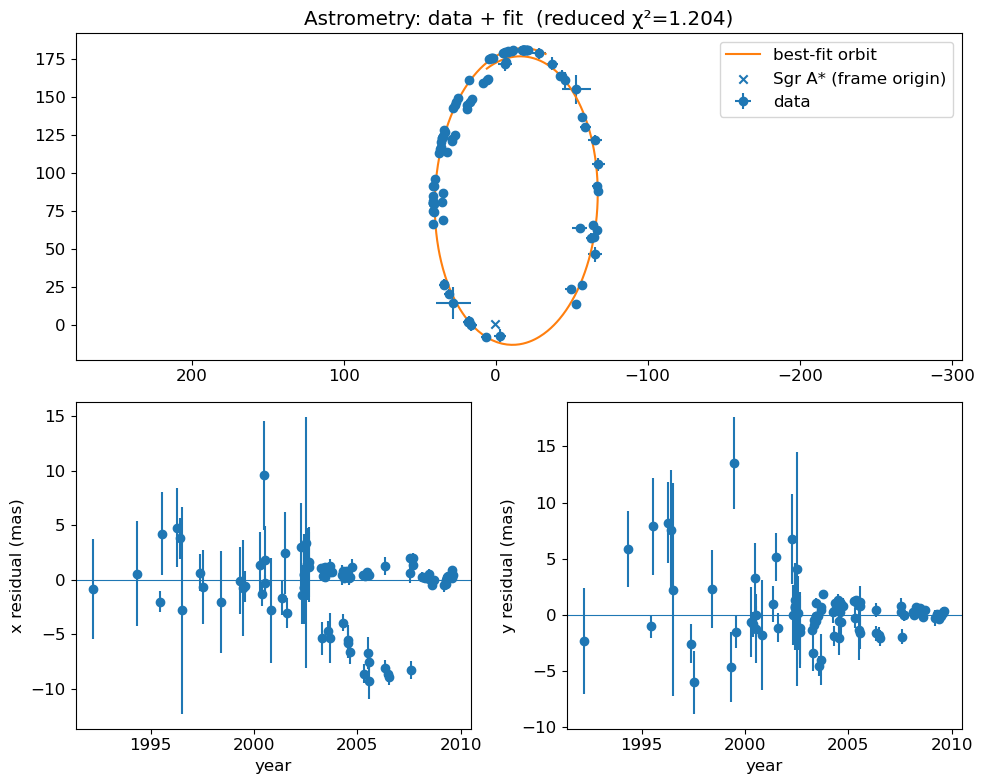

In [268]:
def compute_chi2_and_plots(df, popt):
    """
    Astrometry-only chi^2 + plots.
    popt indices:
      0..6  : a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year
      7     : R0_kpc
      8..11 : x0_mas, y0_mas, vx0_masyr, vy0_masyr
      12    : log_s_xy
    """
    # unpack
    a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year = popt[:7]
    R0_kpc = popt[7]
    x0, y0, vx0, vy0 = popt[8], popt[9], popt[10], popt[11]
    log_s_xy = popt[12]
    s_xy = np.exp(log_s_xy)

    # data
    t = df['year'].values
    xobs = df['x_mas'].values
    yobs = df['y_mas'].values
    xerr = df['x_err_mas'].values
    yerr = df['y_err_mas'].values

    # model
    xmod, ymod, _, _ = orb_elements_to_sky(
        t, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0
    )

    # chi^2
    denom_x = np.sqrt(xerr**2 + s_xy**2)
    denom_y = np.sqrt(yerr**2 + s_xy**2)
    chi2_ast = np.sum(((xobs - xmod)/denom_x)**2 + ((yobs - ymod)/denom_y)**2)
    N_ast = 2 * len(t)
    N_params = len(popt)
    dof = N_ast - N_params
    red = chi2_ast / max(dof, 1)

    print(f"Global chi2 = {chi2_ast:.2f}, dof = {dof}, reduced chi2 = {red:.3f}")
    print(f"  Jitter: s_xy = {s_xy:.3f} mas  |  R0 = {R0_kpc:.3f} kpc")

    # -------- Plots --------
    # Orbit on sky
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.errorbar(xobs, yobs, xerr=xerr, yerr=yerr, fmt='o', label='data')
    t_fine = np.linspace(t.min() - 1, t.max() + 1, 1000)
    xfit, yfit, _, _ = orb_elements_to_sky(
        t_fine, a_mas, e, i_deg, Omega_deg, omega_deg, P_years, T0_year,
        x0_mas=x0, y0_mas=y0, vx0_masyr=vx0, vy0_masyr=vy0
    )
    plt.plot(xfit, yfit, '-', label='best-fit orbit')
    plt.scatter([x0], [y0], marker='x', label='Sgr A* (frame origin)')
    plt.gca().invert_xaxis()
    plt.axis('equal')
    plt.legend()
    plt.title(f'Astrometry: data + fit  (reduced χ²={red:.3f})')

    # Residuals vs time (mas)
    plt.subplot(223)
    plt.errorbar(df['year'], xobs - xmod, yerr=xerr, fmt='o')
    plt.axhline(0, linewidth=0.8)
    plt.xlabel('year'); plt.ylabel('x residual (mas)')

    plt.subplot(224)
    plt.errorbar(df['year'], yobs - ymod, yerr=yerr, fmt='o')
    plt.axhline(0, linewidth=0.8)
    plt.xlabel('year'); plt.ylabel('y residual (mas)')

    plt.tight_layout()
    plt.show()

# call as before:
compute_chi2_and_plots(df, popt)

